In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
sns.set_style("whitegrid")

## Reading Data

In [84]:
#layout file describing all columns
layout = pd.read_csv('public_layout.csv')

In [3]:
layout.head()

,Variable Name,Variable Label,Variable Order in File,Variable Type,Length
0,DOEID,Unique identifier for each respondent,1,Character,5
1,REGIONC,Census Region,2,Numeric,8
2,DIVISION,Census Division,3,Numeric,8
3,REPORTABLE_DOMAIN,Reportable states and groups of states,4,Numeric,8
4,TYPEHUQ,Type of housing unit,5,Numeric,8


In [8]:
layout.shape

(931, 5)

There are 931 columns total.

In [85]:
data = pd.read_csv('recs2009_public.csv')

In [59]:
data.shape

(12083, 931)

In [10]:
data.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER
0,1,2,4,12,2,2471.679705,4742,1080,4953,1271,...,0,-2,-2,-2,-2,-2,-2,-2,-2,-2
1,2,4,10,26,2,8599.172010,2662,199,2688,143,...,0,1,1,0,-2,-2,-2,-2,-2,-2
2,3,1,1,1,5,8969.915921,6233,505,5741,829,...,0,3,5,3,-2,-2,-2,-2,-2,-2
3,4,2,3,7,2,18003.639600,6034,672,5781,868,...,3,3,5,3,-2,-2,-2,-2,-2,-2
4,5,1,1,1,3,5999.605242,5388,702,5313,797,...,0,1,1,0,-2,-2,-2,-2,-2,-2


In [4]:
#some useful functions for looking up data

def whatis(column):
    #get column description
    return layout.loc[layout['Variable Name'] == column,'Variable Label'].values[0]

def search_columns(term):
    #search for columns contain term
    df = layout.loc[layout['Variable Label'].str.contains(term,case=False),['Variable Name','Variable Label']]
    return df

In [20]:
whatis('REGIONC')

'Census Region'

In [22]:
search_columns('Region')

,Variable Name,Variable Label
1,REGIONC,Census Region
10,Climate_Region_Pub,Building America Climate Region (collapsed for...


For this analysis, we are only interested in single-family houses. We are excluding apartments and mobile homes, so we need to remove those housing types. 

In [60]:
data['TYPEHUQ'].value_counts()

2    7803
5    1923
4     926
3     890
1     541
Name: TYPEHUQ, dtype: int64

Single-family detached is type 2, and single-family attached is type 3. 

In [21]:
data = data[data['TYPEHUQ'].isin([2,3])]

In [22]:
data.shape

(8693, 931)

## Exploratory Data Analysis

Electricity usage

In [63]:
print 'Mean, Std:', data['KWH'].mean(), data['KWH'].std()

Mean, Std: 12712.1628897 7913.78716793


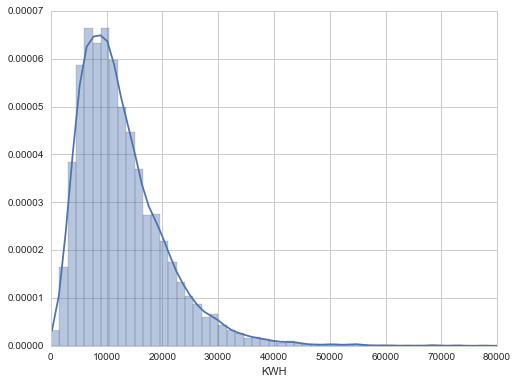

In [64]:
fig, ax = plt.subplots(figsize=[8,6])
ax.set_xlim(0,80000)
sns.distplot(data['KWH'],ax=ax, bins=100)

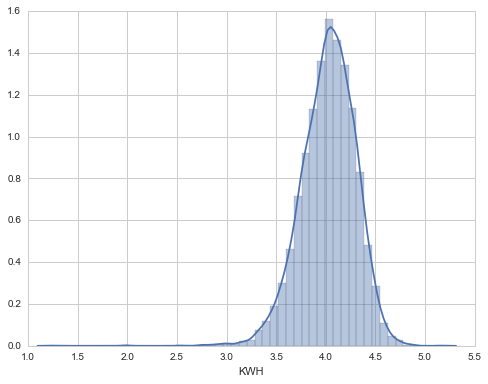

In [65]:
#Log plot
fig, ax = plt.subplots(figsize=[8,6])
#ax.set_xlim(0,80000)
sns.distplot(data['KWH'].map(math.log10),ax=ax)

Look for outliers in KWH.

In [66]:
#Looking for data with log(KWH) larger than 3 standard deviation from the mean.
log_kwh = data['KWH'].map(math.log10)
print 'Data > 3*Sigma:'
print data.loc[log_kwh > (log_kwh.mean()+3.*log_kwh.std()), 'KWH']

#Data with KWH larger than 60000
print 'Data > 60,000 KWH:'
print data.loc[data['KWH']>60000, 'KWH']

Data > 3*Sigma:
3551    150254
4839     72865
8112     77622
9129     72725
Name: KWH, dtype: int64
Data > 60,000 KWH:
1362      60183
3551     150254
4212      68382
4418      69007
4712      68289
4839      72865
8112      77622
9129      72725
10220     64232
Name: KWH, dtype: int64


There seem to be one entry with an unusually large KWH. Entry 3551. 

In [36]:
print 'SQRT:', data.loc[3551,'TOTSQFT_EN'], 'Rooms:', data.loc[3551,'TOTROOMS']

 SQRT: 9545 Rooms: 23


In [86]:
#Removing this entry
data = data.drop(3551)

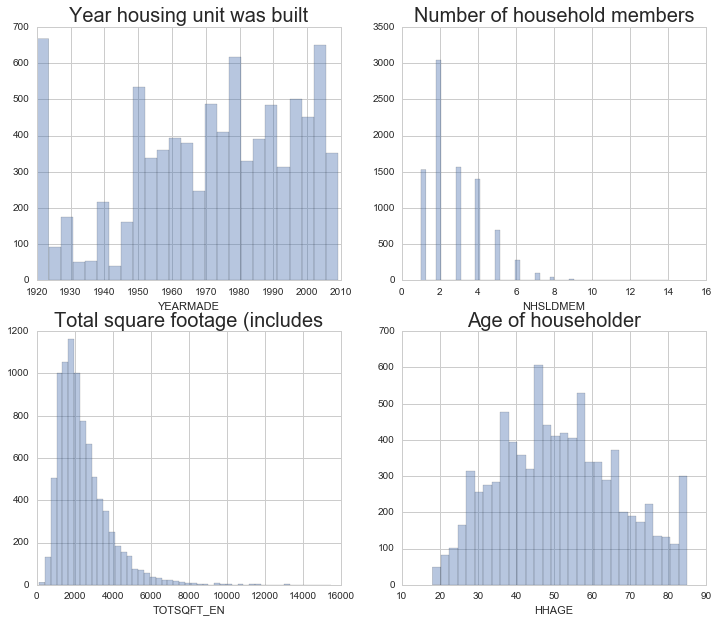

In [68]:
fig, axarr = plt.subplots(2,2,figsize=[12,10])
col = ['YEARMADE','NHSLDMEM','TOTSQFT_EN','HHAGE']
for i in range(4):
    axarr.flatten()[i].set_title(whatis(col[i])[:30],size=20)
    sns.distplot(data[col[i]],ax=axarr.flatten()[i],kde=False)


Some of these bins suggest some sensored data. For example, the year made started from 1920. Houses built prior to that year might be put as 1920. We can look at the imputation flag to see how many of these data points were imputed.

In [69]:
data['ZYEARMADE'].value_counts()

0    7882
1     810
Name: ZYEARMADE, dtype: int64

In [70]:
data.loc[data['YEARMADE']==1920,'ZYEARMADE'].value_counts()

0    534
1     90
Name: ZYEARMADE, dtype: int64

Only about 15% were imputed. The number for 1920 is quite high. I wonder if this has something to do with the survey itself. We don't see any house that were built prior to 1920 eventhough the year range is reported to be 1600-2009.

Explore some other important features.

In [72]:
from sklearn.utils import resample

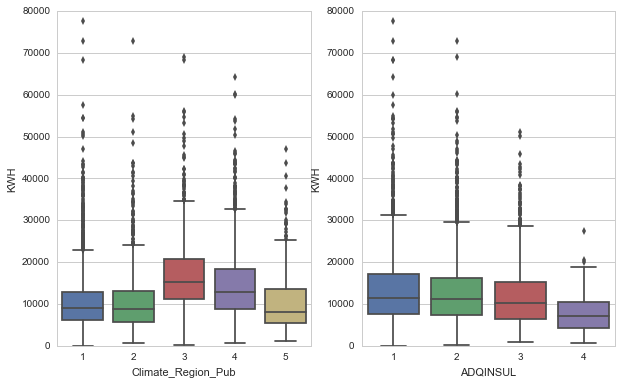

In [73]:
#Looking at some categorical features
fig, axarr = plt.subplots(1,2,figsize=[10,6])
sns.boxplot(ax=axarr[0],data=data,x='Climate_Region_Pub',y='KWH')
sns.boxplot(ax=axarr[1],data=data,x='ADQINSUL',y='KWH')

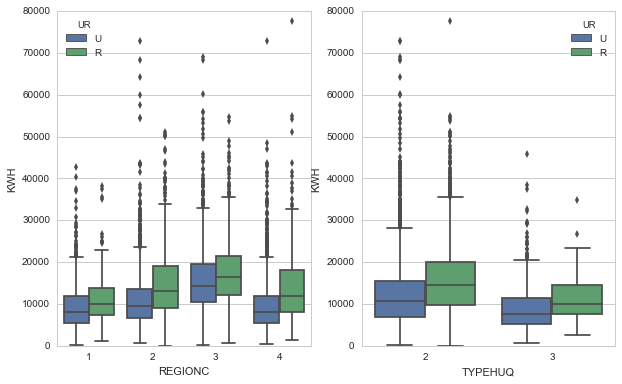

In [74]:
fig, axarr = plt.subplots(1,2,figsize=[10,6])
sns.boxplot(ax=axarr[0],data=data,x='REGIONC',y='KWH',hue='UR')
sns.boxplot(ax=axarr[1],data=data,x='TYPEHUQ',y='KWH',hue='UR')

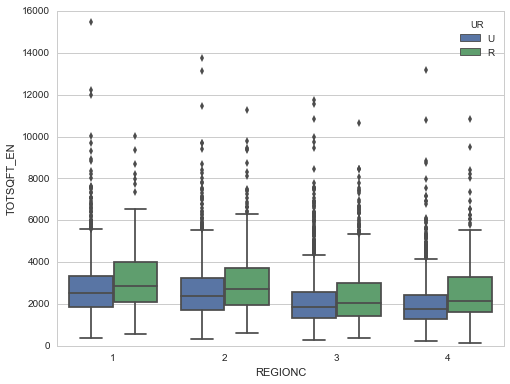

In [76]:
fig, ax = plt.subplots(figsize=[8,6])
sns.boxplot(ax=ax,data=data,x='REGIONC',y='TOTSQFT_EN',hue='UR')

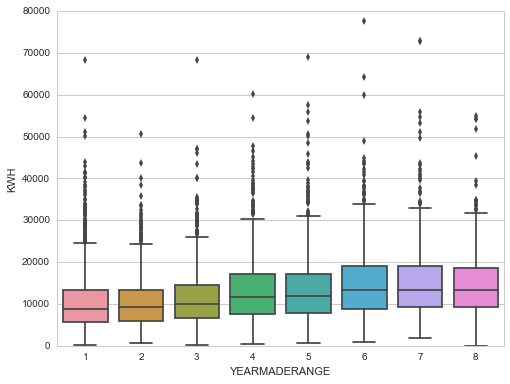

In [80]:
fig, ax = plt.subplots(figsize=[8,6])
sns.boxplot(ax=ax,data=data,x='YEARMADERANGE',y='KWH')

In [78]:
#Since we have more than 10k samples, we are resampling them for visualization purposes. 
subdata = resample(data, replace=False, n_samples= 500, random_state=42)

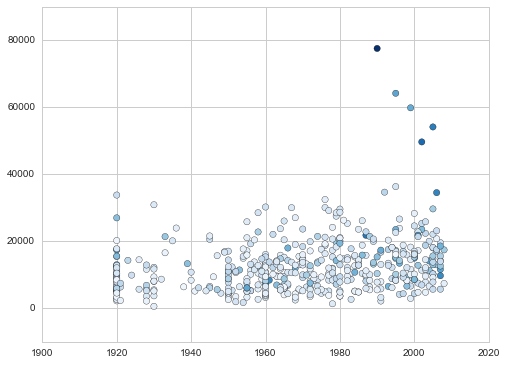

In [79]:
fig, ax = plt.subplots(figsize=[8,6])
ax.scatter(subdata['YEARMADE'],subdata['KWH'],c=subdata['TOTSQFT_EN'],cmap='Blues',s=40)

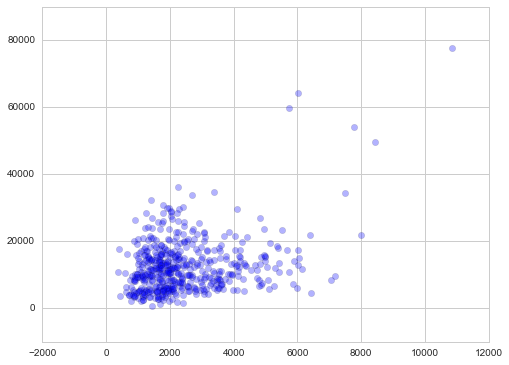

In [82]:
fig, ax = plt.subplots(figsize=[8,6])
ax.scatter(subdata['TOTSQFT_EN'],subdata['KWH'],s=40,alpha=0.3)

## Modeling

### Linear Regression Models

Simple regression model. How well can we predict electricity usage from few, main features?

In [44]:
#calculating error
def rms_error(y_pred,y_true):
    mse = np.mean((y_pred - y_true)**2)
    return math.sqrt(mse)

In [45]:
col_list= ['Climate_Region_Pub','YEARMADE','NHSLDMEM','TOTSQFT_EN']
quan_col = ['YEARMADE','NHSLDMEM','TOTSQFT_EN']
qual_col = ['Climate_Region_Pub']

In [85]:
search_columns('region')

,Variable Name,Variable Label
1,REGIONC,Census Region
10,Climate_Region_Pub,Building America Climate Region (collapsed for...


In [46]:
df = data[col_list]

In [47]:
df.count()

Climate_Region_Pub    8692
YEARMADE              8692
NHSLDMEM              8692
TOTSQFT_EN            8692
dtype: int64

Calculating Pearson correlation coefficient for the quantitative columns

In [48]:
from scipy.stats.stats import pearsonr

In [110]:
for col in quan_col:
    corcoef = pearsonr(df[col],data['KWH'])
    print "%s: %8.2f P-value: %8.2f" % (col,corcoef[0],corcoef[1])

YEARMADE:     0.21 P-value:     0.00
NHSLDMEM:     0.24 P-value:     0.00
TOTSQFT_EN:     0.28 P-value:     0.00


All the correlation coefficients are positive but not very large. All of the p-values are less than 0.01. They are all significant (using the confidence level of 0.05), which is to be expected considering the large number of samples we have.  

In [49]:
#Encoding Categorical data
df = pd.get_dummies(df,columns=['Climate_Region_Pub'],prefix='Climate_Region_Pub',drop_first=True)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import f_regression

Try a very simplistic linear model to see how well it does. 

In [50]:
X = df.values
y = data['KWH'].values.reshape(-1,1)
X.shape, y.shape

((8692, 7), (8692, 1))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [52]:
clf.coef_

array([[  3.28022887e+01,   1.08349225e+03,   1.59743302e+00,
          5.16197507e+02,   6.66670841e+03,   3.64819589e+03,
          4.32411750e+02]])

In [53]:
print 'Train set r^2:', clf.score(X_train,y_train)
print 'Test set r^2:', clf.score(X_test,y_test)

Train set r^2: 0.253876175818
Test set r^2: 0.246793262508


In [54]:
f_value, p_value = f_regression(X,y.flatten())

In [55]:
for i in xrange(len(f_value)):
    print df.columns[i],'F-value:',"%6.0f" % f_value[i],' P-value:',"%5.2f" % p_value[i]
    

YEARMADE F-value:    410  P-value:  0.00
NHSLDMEM F-value:    518  P-value:  0.00
TOTSQFT_EN F-value:    743  P-value:  0.00
Climate_Region_Pub_2 F-value:    114  P-value:  0.00
Climate_Region_Pub_3 F-value:    489  P-value:  0.00
Climate_Region_Pub_4 F-value:    168  P-value:  0.00
Climate_Region_Pub_5 F-value:     48  P-value:  0.00


In [56]:
rms_error(clf.predict(X_test),y_test)

6855.649902293099

#### SLR on Housing Characteristics

In [57]:
col = ['REGIONC','TYPEHUQ','HDD65','CDD65','Climate_Region_Pub','AIA_Zone','METROMICRO','UR','YEARMADE','WALLTYPE',
      'ROOFTYPE','STORIES','BEDROOMS','NCOMBATH','NHAFBATH','OTHROOMS','CELLAR','CRAWL','CONCRETE','ATTIC',
      'HEATHOME','AIRCOND','HIGHCEIL','CATHCEIL','POOL','WINDOWS','ADQINSUL','TOTSQFT_EN']
n_features = len(col)

In [58]:
search_columns('METRO')

,Variable Name,Variable Label
12,METROMICRO,Housing unit in Census Metropolitan Statistica...


In [87]:
df = data[col]

In [88]:
#Fixing binary data with N/A(-2) entries
fix_col=['CELLAR','CRAWL','CONCRETE','ATTIC','HIGHCEIL','CATHCEIL','POOL']
df.loc[:,fix_col] = df[fix_col].applymap(lambda x: 0 if x==-2 else x)

#Encoding Categorical data
cat_col = ['REGIONC','TYPEHUQ','Climate_Region_Pub','AIA_Zone','METROMICRO','UR','WALLTYPE','ROOFTYPE',
           'STORIES','ADQINSUL']
df = pd.get_dummies(df,columns=cat_col,prefix=cat_col,drop_first=True)

In [27]:
df.head()

,HDD65,CDD65,YEARMADE,BEDROOMS,NCOMBATH,NHAFBATH,OTHROOMS,CELLAR,CRAWL,CONCRETE,...,ROOFTYPE_6,ROOFTYPE_7,ROOFTYPE_8,STORIES_20,STORIES_31,STORIES_32,STORIES_40,ADQINSUL_2,ADQINSUL_3,ADQINSUL_4
0,4742,1080,2004,4,1,2,5,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2662,199,1998,3,2,1,1,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,6034,672,1985,3,2,1,4,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5388,702,1983,2,1,1,3,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,8866,270,1920,3,1,0,3,1,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [89]:
X = df.values
y = data['KWH'].values
X.shape, y.shape

((12082, 60), (12082,))

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [91]:
print 'Train set r^2:', clf.score(X_train,y_train)
print 'Test set r^2:', clf.score(X_test,y_test)

Train set r^2: 0.424521370182
Test set r^2: 0.407699238861


In [92]:
rms_error(clf.predict(X_test),y_test)

5762.850829279145

In [93]:
residuals = y - clf.predict(X)

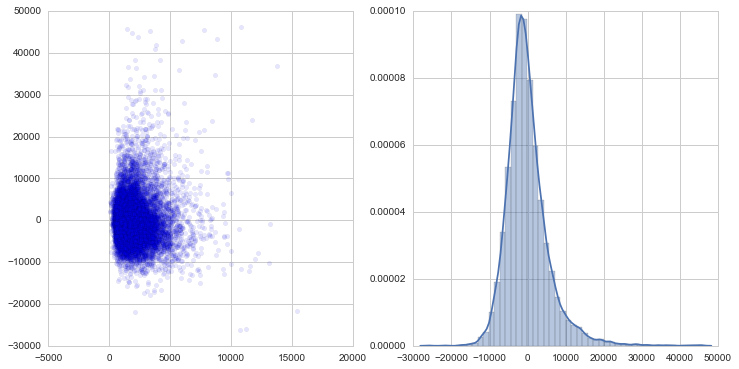

In [94]:
fig, axarr = plt.subplots(1,2,figsize=[12,6])
axarr[0].scatter(df['TOTSQFT_EN'],residuals,alpha=0.1)
sns.distplot(residuals, ax=axarr[1])

#### Ridge Regression

In [107]:
from sklearn.linear_model import Ridge

In [126]:
clf = Ridge(alpha=1)
clf.fit(X_train,y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [127]:
clf.score(X_test,y_test)

0.40778360151794713

### Random Forest

In [95]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
#CV 
params = {'max_features': np.linspace(math.sqrt(n_features),n_features,num=5,dtype='int'),
         'min_samples_leaf': range(1,50,10)}
clf = RandomForestRegressor()
CV = GridSearchCV(clf, param_grid=params)
CV.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([ 5, 10, 16, 22, 28]), 'min_samples_leaf': [1, 11, 21, 31, 41]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [98]:
CV.best_params_

{'max_features': 22, 'min_samples_leaf': 11}

In [99]:
clf = RandomForestRegressor(max_features=CV.best_params_['max_features'],
                           min_samples_leaf=CV.best_params_['min_samples_leaf'])
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=22, max_leaf_nodes=None, min_samples_leaf=11,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [100]:
scores = []
for n in xrange(1,30,4):
    clf = RandomForestRegressor(n_estimators=n,
        max_features=CV.best_params_['max_features'],
        min_samples_leaf=CV.best_params_['min_samples_leaf'])
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))

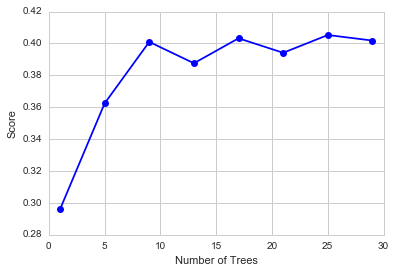

In [101]:
fig, ax = plt.subplots()
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Score')
plt.plot(xrange(1,30,4),scores,'bo-')

In [102]:
print 'Train set r^2:', clf.score(X_train,y_train)
print 'Test set r^2:', clf.score(X_test,y_test)

Train set r^2: 0.568386657075
Test set r^2: 0.401828222892


In [103]:
rms_error(clf.predict(X_test),y_test)

5791.341726501673

In [104]:
feat_imp = pd.DataFrame(index=df.columns)
feat_imp['imp'] = clf.feature_importances_

In [129]:
feat_imp.sort_values(by='imp', ascending=False)

,imp
BEDROOMS,0.145956
TOTSQFT_EN,0.129885
REGIONC_3,0.111433
NCOMBATH,0.091249
CDD65,0.084732
HDD65,0.052305
TYPEHUQ_2,0.051187
UR_U,0.043906
YEARMADE,0.038775
OTHROOMS,0.025858


In [164]:
len(clf.feature_importances_)

54

### Feature Selection

In [128]:
from sklearn.feature_selection import SelectKBest

In [132]:
house_categ = ['REGIONC','DIVISION','REPORTABLE_DOMAIN','TYPEHUQ','Climate_Region_Pub','AIA_Zone',
              'METROMICRO','UR','KOWNRENT','CONDCOOP','WALLTYPE','ROOFTYPE','FUELHEAT','COOLTYPE',
              'USECENAC','FUELPOOL','TYPEGLASS','ADQINSUL','PELHEAT','PELAC']
house_quant = ['HDD65','CDD65','HDD30YR','CDD30YR','YEARMADE','STORIES','BEDROOMS','NCOMBATH','NHAFBATH',
              'OTHROOMS','TOTROOMS','ACROOMS','NUMBERAC','DOOR1SUM','WINDOWS','TOTSQFT_EN','TOTHSQFT','TOTCSQFT']
house_bin = ['CELLAR','CRAWL','CONCRETE','BASEFIN','BASEHEAT','BASECOOL','ATTIC','ATTICFIN','ATTCHEAT',
            'ATTCCOOL','GARGHEAT','PROTHERM','DUCTS','CENACHP','PROTHERMAC','HIGHCEIL','CATHCEIL','POOL',
             'HEATHOME','ELWARM','ELCOOL','ELWATER','ONSITE']

mem_quant = ['NHSLDMEM','HHAGE','MONEYPY']
mem_bin = ['HUPROJ','ATHOME']

In [136]:
df = data[house_categ+house_quant+house_bin+mem_quant+mem_bin]

In [137]:
#Fixing binary data with N/A(-2) entries
df.loc[:,house_bin+mem_bin] = df[house_bin+mem_bin].applymap(lambda x: 0 if x==-2 else x)

#Encoding Categorical data
df = pd.get_dummies(df,columns=house_categ,prefix=house_categ,drop_first=True)

In [138]:
df.shape

(12082, 152)

In [139]:
X = df.values
y = data['KWH'].values

In [187]:
KBest = SelectKBest(f_regression,k=50)
KBest.fit(X,y)

SelectKBest(k=50, score_func=<function f_regression at 0x115821de8>)

In [176]:
KBest_df = pd.DataFrame(index=df.columns)
KBest_df['score'] = KBest.scores_
KBest_df['p_value'] = KBest.pvalues_

In [167]:
KBest_df.sort_values(by='score',ascending=False).head(30)

,score,p_value
TOTCSQFT,3649.077658,0.000000e+00
ACROOMS,2820.767832,0.000000e+00
TOTROOMS,2811.157650,0.000000e+00
NCOMBATH,2508.198236,0.000000e+00
TOTHSQFT,2399.812919,0.000000e+00
BEDROOMS,2370.632732,0.000000e+00
TOTSQFT_EN,1996.783256,0.000000e+00
USECENAC_3,1688.132420,0.000000e+00
OTHROOMS,1644.210999,0.000000e+00
ELWATER,1621.596922,0.000000e+00


In [188]:
X.shape

(12082, 152)

In [189]:
X_30 = KBest.transform(X)

In [190]:
X_30.shape

(12082, 50)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X_30, y, test_size=0.2, random_state=42)
clf = Ridge(alpha=1)
clf.fit(X_train,y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [192]:
clf.score(X_test,y_test)

0.53616445803697466

In [193]:
#CV 
params = {'max_features': np.linspace(math.sqrt(n_features),n_features,num=5,dtype='int'),
         'min_samples_leaf': range(1,50,10)}
clf = RandomForestRegressor()
CV = GridSearchCV(clf, param_grid=params)
CV.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': array([ 5, 10, 16, 22, 28]), 'min_samples_leaf': [1, 11, 21, 31, 41]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [194]:
clf = RandomForestRegressor(max_features=CV.best_params_['max_features'],
                           min_samples_leaf=CV.best_params_['min_samples_leaf'])
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=28, max_leaf_nodes=None, min_samples_leaf=11,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [195]:
clf.score(X_train,y_train)

0.68240555787840407

In [196]:
clf.score(X_test,y_test)

0.50807892715638026